In [1]:
import pandas as pd 
import glob

In [22]:
CC_PATH = glob.glob('./Results/RemoveHighFD/*penBrain0.3penMW0.5*.csv')
# seed_path = pd.read_csv('./data/CS_MeanFD_imp.csv', header=0, index_col=None)
print CC_PATH

['./Results/RemoveHighFD\\allInstances_penBrain0.3penMW0.5.csv', './Results/RemoveHighFD\\BOOTS_penBrain0.3penMW0.5.csv', './Results/RemoveHighFD\\LOSO_penBrain0.3penMW0.5_new.csv']


In [23]:
df_ALL = pd.read_csv(CC_PATH[0], header=0, index_col=0) 
df_BOOTS = pd.read_csv(CC_PATH[1], header=0, index_col=0) 
# df_BOOTSFD = pd.read_csv(CC_PATH[2], header=0, index_col=0) 
# df_LOSO = pd.read_csv(CC_PATH[2], header=0, index_col=0) 

In [24]:
df_ALL = pd.concat([df_ALL.iloc[:, 4], df_ALL.iloc[:, 1], df_ALL.iloc[:, 4+13], df_ALL.iloc[:, 1+13]], axis=1)
df_BOOTS = pd.concat([df_BOOTS.iloc[:, 7], df_BOOTS.iloc[:, 8], df_BOOTS.iloc[:, 7+13], df_BOOTS.iloc[:, 8+13]], axis=1)
# df_BOOTSFD = pd.concat([df_BOOTSFD.iloc[:, 0], df_BOOTSFD.iloc[:, 2], df_BOOTSFD.iloc[:, 0+13], df_BOOTSFD.iloc[:, 2+13]], axis=1)
# df_LOSO = pd.concat([df_LOSO.iloc[:, 5], df_LOSO.iloc[:, 1], df_LOSO.iloc[:, 5+13], df_LOSO.iloc[:, 1+13]], axis=1)

In [6]:
import numpy as np

In [7]:
def z_score(Y):
    '''
    zscore a 2-D data matrix.
    '''
    S = Y.sum(axis=0) / Y.shape[0]
    Y -= S[np.newaxis, :]
    var = (Y ** 2).sum(axis=0) / Y.shape[0]
    var[var == 0] = 1
    Y /= np.sqrt(var)
    return Y

In [25]:
z_BOOTS = z_score(df_BOOTS.values)
comp1_BOOTS = (z_BOOTS[:,0] + z_BOOTS[:,2])/2
comp2_BOOTS = (z_BOOTS[:,1] + z_BOOTS[:,3])/2

z_ALL = z_score(df_ALL.values)
comp1_ALL = (z_ALL[:,0] + z_ALL[:,2])/2
comp2_ALL = -(z_ALL[:,1] + z_ALL[:,3])/2

# z_BOOTSFD = z_score(df_BOOTSFD.values)
# comp1_BOOTSFD = (z_BOOTSFD[:,0] + z_BOOTSFD[:,2])/2
# comp2_BOOTSFD = (z_BOOTSFD[:,1] + z_BOOTSFD[:,3])/2

# z_LOSO = z_score(df_LOSO.values)
# comp1_LOSO = (z_LOSO[:,0] + z_LOSO[:,2])/2
# comp2_LOSO = (z_LOSO[:,1] + z_LOSO[:,3])/2

In [9]:
# FSL EVs
subj_subset = df_BOOTS.index - 1

df_SCA = seed_path.loc[subj_subset]
Y = np.array(df_SCA.values[:,1:])
S = Y.sum(axis=0) / Y.shape[0]
Y -= S[np.newaxis, :]
var = (Y ** 2).sum(axis=0) / Y.shape[0]
Y /= np.sqrt(np.float64(var))
df_SCA['MeanFD_Power'] = Y[:,0]
df_SCA['MeanFD_Jenkinson'] = Y[:,1]

# df_EVs = pd.DataFrame({
#                        'SCCA_BOOTS_1_THOUGHTS': z_BOOTS[:,2],
#                        'SCCA_BOOTS_2_THOUGHTS': -z_BOOTS[:,3],
#                       }, index=subj_subset)
# pd.concat([df_SCA, df_EVs], axis=1).to_csv('Results\DMN_16_REVISION\DMN16_FSL_EV_correct.csv')

In [26]:
# save for spss
idx = df_ALL.index
# idx_FD = df_BOOTSFD.index

# FD_out = []
# for i in idx:
#     if i not in idx_FD:
#         FD_out.append(i)
# print FD_out

df_all = pd.DataFrame({'SCCA_BOOTS_1_REVISION': comp1_BOOTS,
             'SCCA_BOOTS_2_REVISION': comp2_BOOTS,
             'SCCA_ALL_1_REVISION': comp1_ALL,
             'SCCA_ALL_2_REVISION': comp2_ALL}, index=idx)
# df_FDO = pd.DataFrame({'SCCA_BOOTSFD_1_REVISION': comp1_BOOTSFD,
#              'SCCA_BOOTSFD_2_REVISION': comp2_BOOTSFD}, index=idx_FD)

pd.concat([df_all, df_SCA], axis=1).to_csv('Results/RemoveHighFD/DMN16.csv')

In [9]:
coeff_TBL = np.corrcoef((comp1_BOOTS, comp2_BOOTS, comp1_LOSO, -comp2_LOSO))

In [10]:
print coeff_TBL

[[ 1.          0.44475178  0.90626171  0.2815235 ]
 [ 0.44475178  1.          0.56739911  0.73184253]
 [ 0.90626171  0.56739911  1.          0.27336838]
 [ 0.2815235   0.73184253  0.27336838  1.        ]]


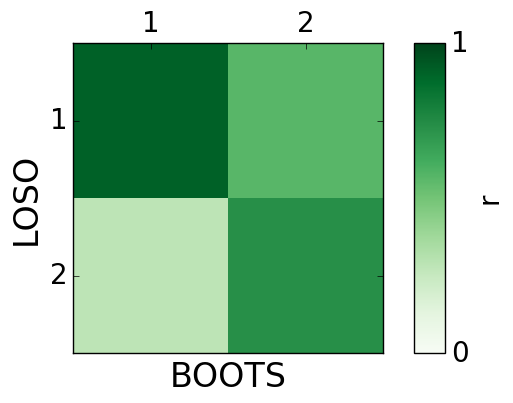

In [26]:
from hierHeatmap import *
df = pd.DataFrame(coeff_TBL[2:,:2], 
                  columns=['1', '2'], 
                  index=['1', '2'])
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(df, vmin=0, vmax=1, interpolation='nearest', cmap=plt.cm.Greens, aspect='equal')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "10%", pad="10%")
cb = plt.colorbar(im, cax=cax, ticks=[0, 1])

# cb.set_ticklabels(fontsize='small') 
cb.set_label('r')

ax.set_yticks(range(df.shape[0]))
ax.set_xticks(range(df.shape[1]))
ax.xaxis.set_ticks_position('top')
ax.set_xticklabels(list(df.columns))
ax.set_yticklabels(list(df.index))
ax.set_xlabel('BOOTS', size='large')
ax.set_ylabel('LODO', size='large')
plt.savefig('Results/CC_Consistency.png', dpi=300, transparent=True, bbox_inches='tight')

plt.show()